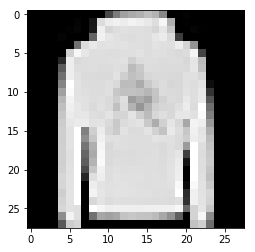

In [27]:
# Import necessary modules
import torch 
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
%matplotlib inline


# Setting the transfomation pipeline each of the image has to go through
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize([0.5], [0.5])
                               ])

# Setting training set and testing set
trainset = datasets.FashionMNIST('~/.pytorch/Fashion-MNIST/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/Fashion-MNIST/', download=True, train=False, transform=transform)

# Define the validation set size
validSize = 0.2

numTrain = len(trainset)
indices = list(range(numTrain))
np.random.shuffle(indices)
splitPoint = int(np.floor(numTrain*validSize))
trainIdx, validIdx = indices[splitPoint:], indices[:splitPoint]


# Defining iterators for training and testing data
numWorkers = 0
batchSize = 64
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, sampler=SubsetRandomSampler(trainIdx), 
                                          num_workers=numWorkers)
validLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, sampler=SubsetRandomSampler(validIdx), 
                                          num_workers=numWorkers)
testLoader = torch.utils.data.DataLoader(testset, batch_size = batchSize, shuffle=True,
                                        num_workers=numWorkers)


# Testing if the iterator is working
images, labels = next(iter(trainLoader))
plt.imshow(images[9,:].view(28,28), cmap='gray')

In [28]:
#Define a model

dropout = nn.Dropout(p=0.2)

model = nn.Sequential(nn.Linear(28*28,128), 
                     nn.ReLU(),
                      dropout,
                     nn.Linear(128, 64),
                     nn.ReLU(),
                      dropout,
                     nn.Linear(64, 32),
                     nn.ReLU(), 
                      dropout,
                     nn.Linear(32, 10), 
                     nn.LogSoftmax(dim=1))

# Define criterion. NLLLoss is a suitable criterion as the last layer in above model is logsoftmax
criterion= nn.NLLLoss()

# Defining the optimizer for training the network. SGD refers to stochastic gradient descent.
optimizer = optim.SGD(model.parameters(), lr = 0.003)

# Epochs refers to the numbers of iterations through the whole data
epochs = 50
validLossMin = np.inf

trainingLosses = []
validLosses = []

for e in range(epochs):
    # Training
    trainingLoss = 0
    validLoss = 0
    
    model.train()
    
    for images, labels in trainLoader:
        
        # Changing images inputs to 2d matrices with number of rows as number of images in each iteration and each row 
        # vector representing a flattened image
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        
        # Calculating the log softmax probabilities
        logps = model(images)
        
        # Calculating the loss
        loss = criterion(logps, labels)
        
        # Calculating the gradients
        loss.backward()
        
        # Updating the weights
        optimizer.step()
        
        # Updating the training loss
        trainingLoss += loss.item()*images.shape[0]
        

        
    trainingLoss = trainingLoss/len(trainLoader.dataset)
    trainingLosses.append(trainingLoss)
    
    model.eval()
    
    for images, labels in validLoader:
        with torch.no_grad():
            # Read comments from the training loop
            images = images.view(images.shape[0], -1)

            logps = model(images)

            loss = criterion(logps, labels)

        validLoss += loss.item()*images.shape[0]
            
    validLoss = validLoss/len(validLoader.dataset)
    validLosses.append(validLoss)
        
    print("Epoch Number :", e+1, ", Training Loss :", trainingLoss, ", Validation Loss :", validLoss)
    
    if validLoss <= validLossMin:
        print("Validation loss decreased from", validLossMin, 'to', validLoss,"Saving model....\n")
        validLossMin = validLoss
        torch.save(model.state_dict(), "model.pt")

        

    


    




Epoch Number : 1 , Training Loss : 1.8053483520507811 , Validation Loss : 0.4310589148203532
Validation loss decreased from inf to 0.4310589148203532 Saving model....

Epoch Number : 2 , Training Loss : 1.5751059157053628 , Validation Loss : 0.32874485613505045
Validation loss decreased from 0.4310589148203532 to 0.32874485613505045 Saving model....

Epoch Number : 3 , Training Loss : 1.181272092183431 , Validation Loss : 0.22782565002441407
Validation loss decreased from 0.32874485613505045 to 0.22782565002441407 Saving model....

Epoch Number : 4 , Training Loss : 0.952872713470459 , Validation Loss : 0.18619995851516724
Validation loss decreased from 0.22782565002441407 to 0.18619995851516724 Saving model....

Epoch Number : 5 , Training Loss : 0.8245579505920411 , Validation Loss : 0.16265821444193523
Validation loss decreased from 0.18619995851516724 to 0.16265821444193523 Saving model....

Epoch Number : 6 , Training Loss : 0.7471457085927328 , Validation Loss : 0.148433327802022

In [4]:
model.load_state_dict(torch.load('model.pt'))

# Testing the model       

correctCases = [0 for i in range(10)]
totalCases = [0 for i in range(10)]

testLoss = 0

for images, labels in testLoader:
    
    optimizer.zero_grad()
    
    images = images.view(images.shape[0], -1)
    
    logps = model(images)
    
    loss = criterion(logps, labels)
    
    testLoss += loss.item()*images.shape[0]
    
    ps = torch.exp(logps) 
    
    topP, topClass = ps.topk(1, dim=1)
    
    equality = topClass == labels.view(*topClass.shape)

    for i in range(len(labels)):
        label = labels[i]
        correctCases[label] += equality[i].item()
        totalCases[label] +=1
    
testLoss = testLoss/len(testLoader.dataset)
        
print("Test Loss :", testLoss)

for label in range(10):
    print("Accuracy for label", label, ":", str(round((100.0*correctCases[label])/totalCases[label],3)) + "%")


Test Loss : 0.1377918032169342
Accuracy for label 0 : 99.082%
Accuracy for label 1 : 98.943%
Accuracy for label 2 : 95.64%
Accuracy for label 3 : 95.545%
Accuracy for label 4 : 95.723%
Accuracy for label 5 : 94.058%
Accuracy for label 6 : 96.764%
Accuracy for label 7 : 94.163%
Accuracy for label 8 : 94.661%
Accuracy for label 9 : 93.756%


Text(0.5, 1.0, 'Correct label : 4, Predicted label : 4')

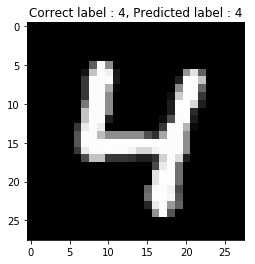

In [26]:
images, labels = next(iter(testLoader))
idx = 5
image = images[idx]
with torch.no_grad():
    logps = model(images[idx].view(1, -1))
    ps = torch.exp(logps)

plt.imshow(image.view(28, 28), cmap='gray')        
plt.title("Correct label : " + str(labels[idx].item()) + ", Predicted label : "+ str(torch.argmax(ps).item()))

In [ ]:
plt.plot(trainingLosses, label='Training Loss')
plt.plot(validLosses, label='Validation Loss')
plt.legend(frameon=False)